# First video tests

In [2]:
# Imports

from PIL import Image
import os, os.path
import numpy as np
import skimage

import matplotlib.pyplot as plt

#scikit-image ???
from skimage.measure import compare_ssim
from skimage.color import rgb2gray
from skimage.io import imread

#for animation
from matplotlib import animation, rc
from IPython.display import HTML

print("Imports done")

Imports done


In [3]:
# Settings

path = "C:/Users/Benjamin/Documents/LTU/Neural Net. and Learn. Machines/101 - Retina Project/peipa/" #already PGM format for first video
img_name = "hand-"
img_format = ".pgm"
full_path = path + img_name

print("Settings saved")

Settings saved


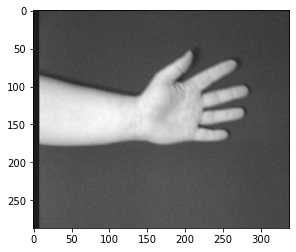

In [4]:
# Open and check images format

img = Image.open(path + img_name + "1" + img_format)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
#variables

#nbr of frame
nbr_frame = len([name for name in os.listdir(path)]) #in case it's already in PGM format

#frame specifications

In [6]:
# Video

# %matplotlib inline

#anim params
ms_int = 20

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, img.size[1]))
ax.set_ylim(( 0, img.size[0]))

im = plt.imshow(np.zeros(np.transpose(img.size)), cmap='gray', vmin=0, vmax=255)

# animation function.  This is called sequentially
def animate(i):
    im.set_array(imread(full_path + str(i+1) + img_format))
    return [im]

# call the animator. blit=True means only re-draw the parts that have changed.
anim1 = animation.FuncAnimation(fig, animate, frames=nbr_frame-2, interval=ms_int, blit=True)

plt.close()
HTML(anim1.to_html5_video())

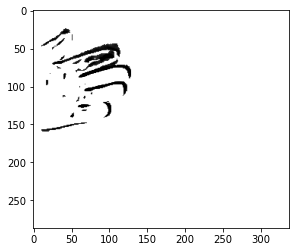

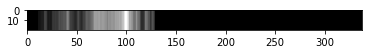

78.9264426831419 23.27638202951978


In [7]:
# Test

#diff params
th = 0.2 #threshold for chgt detection

# load the two input images
full_path = path + img_name
grayA = imread(full_path + "45" + img_format)
grayB = imread(full_path + "46" + img_format)

# compute ssim (struc sim)
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff[diff>th] = 1
plt.imshow(diff, cmap='gray', vmin=0, vmax=1)
plt.show()

# mean on column
col_mean = np.array(1 - diff).sum(0) # 1 - values to inverse
col_mean /= max(col_mean) # one way to do it

h = 20
col_mean_graph = np.tile((col_mean), (h, 1))
plt.imshow(col_mean_graph, cmap='gray', vmin=0, vmax=1)
plt.show()

values = np.array([col_mean[i]*i for i in range(len(col_mean))])
mean = values.sum() / col_mean.sum()

values = np.array([abs(i-mean)*col_mean[i] for i in range(len(col_mean))])
var = values.sum() / col_mean.sum()

print(mean,var)

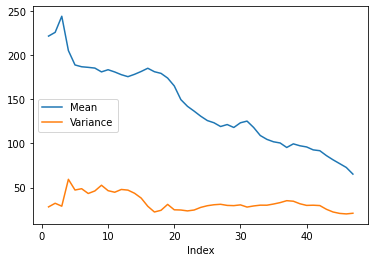

In [8]:

# compute column mean and var between two grayscaled images

#diff params
th = 0.1 #threshold for chgt detection

#if a result = None, then no diff detected between the two images
def get_mvt_data(grayA,grayB):
    # compute ssim (struc sim)
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    diff[diff>th] = 1

    # reduce to 1D (column)
    col_mean = np.array(1 - diff).sum(0) # 1 - values to inverse and compute according to max of diff

    if col_mean.sum() == 0:
        return {"m": None,"v": None}

    else:
        col_mean /= max(col_mean)
        values = np.array([col_mean[i]*i for i in range(len(col_mean))])
        mean = values.sum() / col_mean.sum()

        values = np.array([abs(i-mean)*col_mean[i] for i in range(len(col_mean))])
        var = values.sum() / col_mean.sum()

        return {"m": mean,"v": var}


# load the two input images
full_path = path + img_name
datas = []
# for i in range(1):
for i in range(nbr_frame - 2):
    A = imread(full_path + str(i+1) + img_format)
    B = imread(full_path + str(i+2) + img_format)
    datas.append(get_mvt_data(A,B))

points = np.zeros((nbr_frame - 1,img.size[0]),int)
for i in range(nbr_frame - 2):
    if datas[i]['m'] != None:
        size = int(round(datas[i]['v']/2,0))
        mean_pixel = int(round(datas[i]['m'],0))
        for j in range(size-1):
            points[i][mean_pixel - j] = 1
            points[i][mean_pixel + j] = 1

plt.plot([datas[i]['m'] for i in range(len(datas))], label="Mean")
plt.plot([datas[i]['v'] for i in range(len(datas))], label="Variance")
plt.legend(loc="center left")
plt.xlabel("Index")
plt.show()

In [9]:
# Average motion animation

# %matplotlib inline

#anim params
ms_int = 100

h = 20 #width
def mult_row(row,h):
    return np.tile((row), (h, 1))

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, img.size[0]))
ax.set_ylim((0, h))

im = plt.imshow(np.zeros((h,img.size[0])), cmap='gray', vmin=0, vmax=1)

# animation function.  This is called sequentially
def animate(i):
    im.set_array(mult_row(points[i+1],h))
    return [im]

# call the animator. blit=True means only re-draw the parts that have changed.
anim2 = animation.FuncAnimation(fig, animate, frames=nbr_frame - 2, interval=ms_int, blit=True)

plt.close()
HTML(anim2.to_html5_video())

In [10]:
HTML(anim1.to_html5_video())

## Proper version

In [64]:
# Imports
from PIL import Image
import os, os.path
import numpy as np
import skimage

import matplotlib.pyplot as plt

#scikit-image ???
from skimage.measure import compare_ssim
from skimage.color import rgb2gray
from skimage.io import imread

print("Imports done")

Imports done


In [ ]:
'''
diff_to_pos(gray1,gray2,th): movement
gray1, gray2: images compared (SSIM algo)
th: is the theshold of maximal likelihood (result of SSIM algo) between 0 and 1

return: probable movement position (mean) and variance of this estimation
'''

def diff_to_pos(gray1,gray2,th):

    # compute ssim (struc sim)
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    diff[diff>th] = 1 #discard little changes

    # reduce to 1D (column)
    col_mean = np.array(1 - diff).sum(0) # 1 - values to inverse and compute according to max of diff

    if col_mean.sum() == 0:
        return {"m": None,"v": None}

    else:
        col_mean /= max(col_mean)
        values = np.array([col_mean[i]*i for i in range(len(col_mean))])
        mean = values.sum() / col_mean.sum()

        values = np.array([abs(i-mean)*col_mean[i] for i in range(len(col_mean))])
        var = values.sum() / col_mean.sum()

        return {"m": mean,"v": var}

In [71]:
'''
pos_to_move(pos1,pos2,th,width): movement
th: minimal movement (% of width) as positions and width are in pixel
return: -1 goes to the left, 1 to the right, 0 not enough changes (based on 2 consecutive movement positions: pos1 and pos2)
'''

def pos_to_move(pos1,pos2,th,width):
    ret = 0
    if ((pos1-pos2)/width > th):
        if (pos1 < pos2):
            ret = 1
        else:
            ret = -1
    return ret


In [62]:
'''
vid_to_movement(frames,move_th,diff_th): movements
frames: is a list of grayscaled frame (at least 3 images)
move_th: is a coefficient for the threshold dection of a minimal movement (if no movement, keep first position in memory)
diff_th: is a threshold for a minimal difference bet

return: an array of relative movements (based on previous frame) -1 goes to the left, 1 to the right, 0 not enough changes
'''

def vid_to_movement(frames,move_th,diff_th):
    frame_arr = np.array(frames)
    img_width = len(frames[0][0])
    pos_list = []
    for i in range(len(frames)-1):
        pos_list.append(diff_to_pos(frame_arr[i],frame_arr[i+1],diff_th))
    
    mv_list = []
    prev_pos = None
    for j in range(len(pos_list)-1):
        move = 0

        if (pos_list[j]['m'] != None):

            if (pos_list[j]['m'] != 0):
                prev_pos = pos_list[j]['m']

            if prev_pos != None:
                move = pos_to_move(prev_pos,pos_list[j+1]['m'],move_th,img_width)
        
        mv_list.append(move)
    
    return mv_list

Settings saved


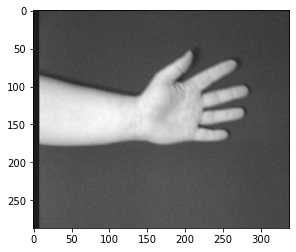

In [70]:
# Settings

path = "C:/Users/Benjamin/Documents/LTU/Neural Net. and Learn. Machines/101 - Retina Project/peipa/" #already PGM format for first video
img_name = "hand-"
img_format = ".pgm"
full_path = path + img_name

framerate = 24 #manual set(FPS)

nbr_frame = len([name for name in os.listdir(path)]) #in case it's not a video file

#using opencv to load video

#getting framerate in case opencv is used:
    # vid=cv2.VideoCapture(path)
    # framerate = vid.get(cv2.CAP_PROP_FPS)

# try: #works only for some version
#     total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
# except:
    # try :
    #     total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
    # except : print("Cannot get framerate from video file")
# nbr_frame = total

print("Settings saved")

# Open and check images format

img = imread(path + img_name + "1" + img_format)
# img = Image.open(path + img_name + "1" + img_format)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

# WARNING already greyscaled pictures
#to grayscale : (may be diff between gray cv2 format and gray scikit format)
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       #opencv
    #img_gray = rgb2gray(img)                               #scikit

# Simulate video
framerate = 24
frames = []
for i in range(nbr_frame-1):
    frames.append(imread(path + img_name + str(i+1) + img_format))

In [72]:

move_th = 0
diff_th = 0.2

result = vid_to_movement(frames,move_th,diff_th)
print(result)

#link result to framerate (for time scalling)

[0, -1, 0, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [67]:
#test live cam (instead of video)

import cv2

cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()

    ######## Code executed on each frame
    # Capture frame-by-frame

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #might have diff between gray cv2 and scikit format

    # Display the resulting frame
    cv2.imshow('frame',gray)
    ########

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
# TODO:
